In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [4]:
image, label = train_dataset[0]
image.shape, label

(torch.Size([3, 224, 224]), 6)

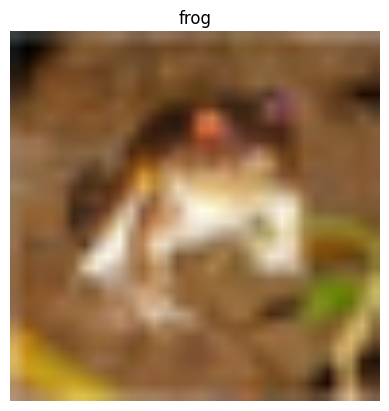

In [5]:
image_np = image.permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]
plt.imshow(image_np)
plt.axis("off")
plt.title(classes[label])
plt.show()

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16)

In [7]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(classes))

for param in model.fc.parameters():
    param.requires_grad = True

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/luu/.local/share/virtualenvs/NSU_DNN-gz_yNHFj/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luu/.local/share/virtualenvs/NSU_DNN-gz_yNHFj/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [9]:
# Train
epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.8213
Epoch 2/5, Loss: 0.6190
Epoch 3/5, Loss: 0.5915
Epoch 4/5, Loss: 0.5748
Epoch 5/5, Loss: 0.5697


In [10]:
# Test
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 80.80%


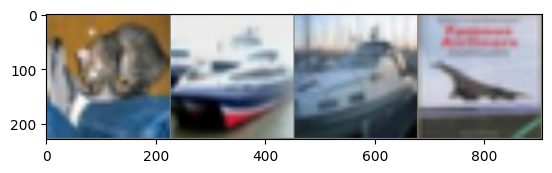

Predicted: cat ship ship plane
Actual: cat ship ship plane


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

preds = model(images)
_, predicted = torch.max(preds, 1)

imshow(torchvision.utils.make_grid(images[:4]))
print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))
print('Actual:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))